In [521]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import *
import numpy as np
import math
import torch
import gpytorch
from sklearn.preprocessing import *

In [522]:
df=pd.read_excel("UGP_Data.xlsx",sheet_name="Data_Model")

In [523]:
df.head()

,wt%,salt [mM],tan delta,delta,Temp,n,noise_n,FD,noise_fd,tg,log_tg,noise_tg,time [h],G',"G""",avg_noise_tg,noise_log_tg,S,log_S,noise_S
0,4.0,3.0,0.247,0.242153,30,0.154159,NaN,2.364575,NaN,30.430000,1.483302,--,--,39.693475,10.931510,28.928000,1.461318,40.751042,1.610139,NaN
1,3.8,3.0,0.275,0.268366,30,0.170847,NaN,2.349030,NaN,34.931000,1.543211,--,--,28.629795,8.905488,28.928000,1.461318,29.501316,1.469841,NaN
2,4.0,0.0,0.287,0.279488,30,0.177928,0.000883,2.342379,0.000831,282.000000,2.450249,0,4.7,53.635362,16.428162,28.928000,1.461318,55.356978,1.743172,21.773822
3,3.8,0.0,0.310,0.300606,30,0.191372,0.00145,2.329658,0.00138,563.333333,2.750765,13.058333,9.388889,39.357156,13.865581,13.058333,1.115888,40.747212,1.610098,12.38365
4,3.6,0.0,0.336,0.324149,30,0.206359,0.000857,2.315331,0.000824,649.033333,2.812267,48.841667,10.817222,31.042231,10.967994,48.841667,1.688790,32.253468,1.508576,9.100433


In [524]:
df['wt%'].describe()

count    46.000000
mean      2.582609
std       0.750497
min       1.200000
25%       2.000000
50%       2.700000
75%       3.000000
max       4.000000
Name: wt%, dtype: float64

In [525]:
dfx=df[["wt%","salt [mM]","Temp"]]
dfy=df[["n","log_tg","log_S"]]

In [526]:
X=np.array(dfx)
y=np.array(dfy)
outputs=["n","log_tg","log_S"]

In [527]:
sc_X=StandardScaler()
X_sc=sc_X.fit_transform(X)

In [528]:
print(sc_X.mean_)
print(sc_X.var_)

[ 2.5826087   3.24347826 30.        ]
[ 0.55100189  5.22941399 21.73913043]


In [529]:
global wt_mean,wt_std,sc_mean,sc_std,temp_mean,temp_std
wt_mean=sc_X.mean_[0]
sc_mean=sc_X.mean_[1]
temp_mean=sc_X.mean_[2]
wt_std=np.sqrt(sc_X.var_[0])
sc_std=np.sqrt(sc_X.var_[1])
temp_std=np.sqrt(sc_X.var_[2])


In [530]:
sc_y=StandardScaler()
y_sc=sc_y.fit_transform(y)

Training Set X 


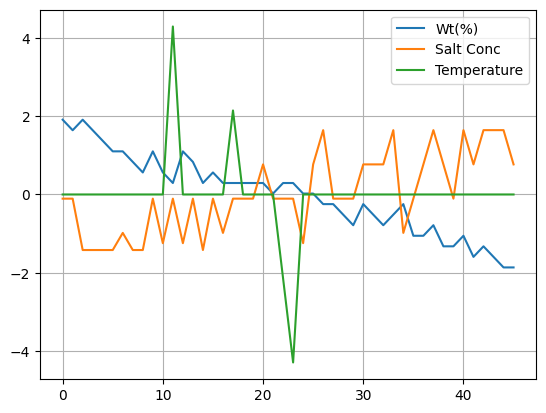

In [531]:
print("Training Set X ")
plt.plot(X_sc)
plt.legend(["Wt(%)","Salt Conc","Temperature"])
plt.grid()

Training Set y 


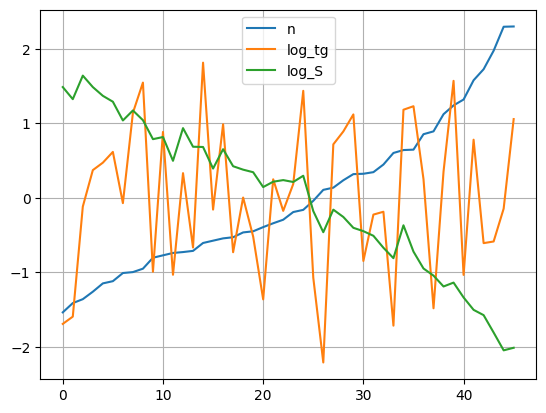

In [532]:
print("Training Set y ")
plt.plot(y_sc)
plt.legend(["n","log_tg","log_S"])
plt.grid()

In [533]:
X_sc=torch.tensor(X_sc)
y_sc=torch.tensor(y_sc)

In [534]:
n=0.4
log_tg=3.2
log_s=-0.02
y_req=np.reshape(np.array([n,log_tg,log_s]),(1,-1))
y_req_sc=sc_y.transform(y_req)

The cost function currently being used estimates the cost based on the difference in the mean predictions and the uncertainity interval length. It penalises softly when either of weight % , salt concentration or temperature goes negative in the synthesis condition.

Optimiser based on Independednt models performs poorly without the penalisation as the numerical gradients blow up due to changes in the uncertainity interval , MOGP however is stable and immune to this. Another cost function which calculates the cost only based on the difference in the mean predictions works well for the independent inference.

In [535]:
def error_est(y_req,pred,lower,upper,cond):
    error=((y_req[0]-pred[0])/(upper[0]-lower[0]))**2+((y_req[1]-pred[1])/(upper[1]-lower[1]))**2+((y_req[2]-pred[2])/(upper[2]-lower[2]))**2
    if(cond[0]<=-wt_mean/wt_std):
        error+=(cond[0]+wt_mean/wt_std)**2
    if(cond[1]<=-sc_mean/sc_std):
        error+=(cond[1]+sc_mean/sc_std)**2
    if(cond[2]<=-temp_mean/temp_std):
        error+=(cond[2]+temp_mean/temp_std)**2
    return error

## Independent Inference using RBF Kernel

In [536]:
likelihood_n = gpytorch.likelihoods.GaussianLikelihood()
likelihood_tg = gpytorch.likelihoods.GaussianLikelihood()
likelihood_s = gpytorch.likelihoods.GaussianLikelihood()

In [537]:
class GK_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GK_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [538]:
print("Training for",outputs[0])
model_gk_n = GK_GP_Model(X_sc,y_sc[:,0], likelihood_n)
training_iter=50

model_gk_n.train()
likelihood_n.train()

# Use the adam optimizer
optimizer_gk = torch.optim.Adam(model_gk_n.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_n, model_gk_n)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer_gk.zero_grad()
    # Output from model
    output_gk = model_gk_n(X_sc)
    # Calc loss and backprop gradients
    loss_gk = -mll(output_gk, y_sc[:,0])
    loss_gk.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
         i + 1, training_iter, loss_gk.item(),
         model_gk_n.covar_module.base_kernel.lengthscale.item(),
         model_gk_n.likelihood.noise.item()
     ))
    optimizer_gk.step()
lengthscale=model_gk_n.covar_module.base_kernel.lengthscale.item()
noise = model_gk_n.likelihood.noise.item()
print("Length scale for the trained RBF Kernel for ",outputs[0]," : ",lengthscale)
print("Noise Parameter of the Gaussian likelihood_n for",outputs[0]," : ",noise)

Training for n
Iter 1/50 - Loss: 1.099   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.061   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.024   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.987   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 0.951   lengthscale: 0.912   noise: 0.513
Iter 6/50 - Loss: 0.915   lengthscale: 0.973   noise: 0.474
Iter 7/50 - Loss: 0.880   lengthscale: 1.035   noise: 0.437
Iter 8/50 - Loss: 0.845   lengthscale: 1.098   noise: 0.402
Iter 9/50 - Loss: 0.810   lengthscale: 1.163   noise: 0.370
Iter 10/50 - Loss: 0.775   lengthscale: 1.229   noise: 0.340
Iter 11/50 - Loss: 0.740   lengthscale: 1.295   noise: 0.312
Iter 12/50 - Loss: 0.705   lengthscale: 1.362   noise: 0.286
Iter 13/50 - Loss: 0.671   lengthscale: 1.429   noise: 0.261
Iter 14/50 - Loss: 0.637   lengthscale: 1.496   noise: 0.239
Iter 15/50 - Loss: 0.604   lengthscale: 1.563   noise: 0.218
Iter 16/50 - Loss: 0.571   lengthscale: 1.631   noise: 0.199
Iter 17/50 - Loss:

Iter 37/50 - Loss: 0.186   lengthscale: 2.998   noise: 0.034
Iter 38/50 - Loss: 0.185   lengthscale: 3.057   noise: 0.033
Iter 39/50 - Loss: 0.185   lengthscale: 3.115   noise: 0.031
Iter 40/50 - Loss: 0.185   lengthscale: 3.172   noise: 0.030
Iter 41/50 - Loss: 0.185   lengthscale: 3.229   noise: 0.030
Iter 42/50 - Loss: 0.185   lengthscale: 3.284   noise: 0.029
Iter 43/50 - Loss: 0.184   lengthscale: 3.338   noise: 0.029
Iter 44/50 - Loss: 0.183   lengthscale: 3.392   noise: 0.029
Iter 45/50 - Loss: 0.181   lengthscale: 3.445   noise: 0.029
Iter 46/50 - Loss: 0.178   lengthscale: 3.498   noise: 0.029
Iter 47/50 - Loss: 0.175   lengthscale: 3.549   noise: 0.029
Iter 48/50 - Loss: 0.172   lengthscale: 3.601   noise: 0.030
Iter 49/50 - Loss: 0.168   lengthscale: 3.652   noise: 0.030
Iter 50/50 - Loss: 0.165   lengthscale: 3.702   noise: 0.031
Length scale for the trained RBF Kernel for  n  :  3.752373456954956
Noise Parameter of the Gaussian likelihood_n for n  :  0.031531888991594315


In [539]:
print("Training for",outputs[1])
model_gk_tg= GK_GP_Model(X_sc,y_sc[:,1], likelihood_tg)
training_iter=50

model_gk_tg.train()
likelihood_tg.train()

# Use the adam optimizer
optimizer_gk = torch.optim.Adam(model_gk_tg.parameters(), lr=0.1)  # Includes Gaussianlikelihood_tg parameters

# "Loss" for GPs - the marginal log likelihood_tg
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_tg, model_gk_tg)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer_gk.zero_grad()
    # Output from model
    output_gk = model_gk_tg(X_sc)
    # Calc loss and backprop gradients
    loss_gk = -mll(output_gk, y_sc[:,1])
    loss_gk.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
         i + 1, training_iter, loss_gk.item(),
         model_gk_tg.covar_module.base_kernel.lengthscale.item(),
         model_gk_tg.likelihood.noise.item()
     ))
    optimizer_gk.step()
lengthscale=model_gk_tg.covar_module.base_kernel.lengthscale.item()
noise = model_gk_tg.likelihood.noise.item()
print("Length scale for the trained RBF Kernel for ",outputs[1]," : ",lengthscale)
print("Noise Parameter of the Gaussian likelihood_tg for",outputs[1]," : ",noise)

Training for log_tg
Iter 1/50 - Loss: 1.125   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.089   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.056   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 1.024   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 0.991   lengthscale: 0.911   noise: 0.513


Iter 6/50 - Loss: 0.958   lengthscale: 0.971   noise: 0.474
Iter 7/50 - Loss: 0.924   lengthscale: 1.032   noise: 0.437
Iter 8/50 - Loss: 0.890   lengthscale: 1.094   noise: 0.402
Iter 9/50 - Loss: 0.856   lengthscale: 1.158   noise: 0.370
Iter 10/50 - Loss: 0.823   lengthscale: 1.222   noise: 0.340
Iter 11/50 - Loss: 0.789   lengthscale: 1.287   noise: 0.312
Iter 12/50 - Loss: 0.755   lengthscale: 1.353   noise: 0.285
Iter 13/50 - Loss: 0.722   lengthscale: 1.419   noise: 0.261
Iter 14/50 - Loss: 0.688   lengthscale: 1.486   noise: 0.238
Iter 15/50 - Loss: 0.654   lengthscale: 1.552   noise: 0.217
Iter 16/50 - Loss: 0.621   lengthscale: 1.620   noise: 0.198
Iter 17/50 - Loss: 0.588   lengthscale: 1.687   noise: 0.181
Iter 18/50 - Loss: 0.555   lengthscale: 1.755   noise: 0.164
Iter 19/50 - Loss: 0.523   lengthscale: 1.823   noise: 0.150
Iter 20/50 - Loss: 0.491   lengthscale: 1.891   noise: 0.136
Iter 21/50 - Loss: 0.460   lengthscale: 1.960   noise: 0.124
Iter 22/50 - Loss: 0.429   l

In [540]:
print("Training for",outputs[2])
model_gk_s= GK_GP_Model(X_sc,y_sc[:,2], likelihood_s)
training_iter=50

model_gk_s.train()
likelihood_s.train()

# Use the adam optimizer
optimizer_gk = torch.optim.Adam(model_gk_s.parameters(), lr=0.1)  # Includes Gaussianlikelihood_s parameters

# "Loss" for GPs - the marginal log likelihood_s
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_s, model_gk_s)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer_gk.zero_grad()
    # Output from model
    output_gk = model_gk_s(X_sc)
    # Calc loss and backprop gradients
    loss_gk = -mll(output_gk, y_sc[:,2])
    loss_gk.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
         i + 1, training_iter, loss_gk.item(),
         model_gk_s.covar_module.base_kernel.lengthscale.item(),
         model_gk_s.likelihood.noise.item()
     ))
    optimizer_gk.step()
lengthscale=model_gk_s.covar_module.base_kernel.lengthscale.item()
noise = model_gk_s.likelihood.noise.item()
print("Length scale for the trained RBF Kernel for ",outputs[2]," : ",lengthscale)
print("Noise Parameter of the Gaussian likelihood_s for",outputs[2]," : ",noise)

Training for log_S
Iter 1/50 - Loss: 1.081   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.041   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.002   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.962   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 0.924   lengthscale: 0.913   noise: 0.513
Iter 6/50 - Loss: 0.886   lengthscale: 0.973   noise: 0.474
Iter 7/50 - Loss: 0.848   lengthscale: 1.035   noise: 0.437
Iter 8/50 - Loss: 0.810   lengthscale: 1.099   noise: 0.402
Iter 9/50 - Loss: 0.773   lengthscale: 1.164   noise: 0.370
Iter 10/50 - Loss: 0.735   lengthscale: 1.231   noise: 0.340
Iter 11/50 - Loss: 0.697   lengthscale: 1.298   noise: 0.311
Iter 12/50 - Loss: 0.659   lengthscale: 1.366   noise: 0.285
Iter 13/50 - Loss: 0.621   lengthscale: 1.434   noise: 0.261
Iter 14/50 - Loss: 0.583   lengthscale: 1.503   noise: 0.238
Iter 15/50 - Loss: 0.545   lengthscale: 1.572   noise: 0.217
Iter 16/50 - Loss: 0.507   lengthscale: 1.641   noise: 0.198
Iter 17/50 - L

In [541]:
wt_guess=2.6
salt_guess=3
temp_guess=30
X_cond=np.reshape(np.array([wt_guess,salt_guess,temp_guess]),(1,-1))
X_cond_sc=sc_X.transform(X_cond)
X_cond_sc=torch.tensor(X_cond_sc)

In [542]:
X_cond_sc

tensor([[ 0.0234, -0.1065,  0.0000]], dtype=torch.float64)

In [543]:
wt_guess=2
salt_guess=3
temp_guess=30
X_cond=np.reshape(np.array([wt_guess,salt_guess,temp_guess]),(1,-1))
X_cond_sc=sc_X.transform(X_cond)
X_cond_sc=torch.tensor(X_cond_sc)

In [544]:
# Set into eval mode
model_gk_n.eval()
likelihood_n.eval()
model_gk_tg.eval()
likelihood_tg.eval()
model_gk_s.eval()
likelihood_s.eval()
grad_step_sz=1e-2
lr_rate=[1e-2,1e-2,1e-2]
J_prev=0
Jcost=100
cost_func=[]
mean_pred=[1,1,1]
lower_pred=[1,1,1]
upper_pred=[1,1,1]
while(abs(J_prev-Jcost)>1e-5):
    print("Begin",X_cond_sc)
    J_prev=Jcost
    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Obtain the predictive mean and covariance matrix
        f_preds_gk = model_gk_n(X_cond_sc)
        # Make predictions by feeding model through likelihood
        observed_pred_gk_n = likelihood_n(model_gk_n(X_cond_sc))
        lower_gk_n, upper_gk_n = observed_pred_gk_n.confidence_region()
    # print("Mean n")
    # print(observed_pred_gk_n.mean)
    # print("Lower n")
    # print(lower_gk_n)
    mean_pred[0]=observed_pred_gk_n.mean.numpy()[0]
    lower_pred[0]=lower_gk_n.numpy()[0]
    upper_pred[0]=upper_gk_n.numpy()[0]
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Obtain the predictive mean and covariance matrix
        f_preds_gk = model_gk_tg(X_cond_sc)
        # Make predictions by feeding model through likelihood
        observed_pred_gk_tg = likelihood_tg(model_gk_tg(X_cond_sc))
        lower_gk_tg, upper_gk_tg = observed_pred_gk_tg.confidence_region()
    # print("Mean tg")
    # print(observed_pred_gk_tg.mean)
    mean_pred[1]=observed_pred_gk_tg.mean.numpy()[0]
    lower_pred[1]=lower_gk_tg.numpy()[0]
    upper_pred[1]=upper_gk_tg.numpy()[0]
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Obtain the predictive mean and covariance matrix
        f_preds_gk = model_gk_s(X_cond_sc)
        # Make predictions by feeding model through likelihood
        observed_pred_gk_s = likelihood_s(model_gk_s(X_cond_sc))
        lower_gk_s, upper_gk_s = observed_pred_gk_s.confidence_region()
    # print("Mean s")
    # print(observed_pred_gk_s.mean)
    mean_pred[2]=observed_pred_gk_s.mean.numpy()[0]
    lower_pred[2]=lower_gk_s.numpy()[0]
    upper_pred[2]=upper_gk_s.numpy()[0]
    Jcost=error_est(y_req_sc[0],np.array(mean_pred),np.array(lower_pred),np.array(upper_pred),X_cond_sc[0])
    print("Parameters Obtained:")
    print(mean_pred)
    print("Cost Func")
    print(Jcost)
    print("Lower Bound:")
    print(lower_pred)
    print("Upper Bound:")
    print(upper_pred)
    grad=[1,1,1]
    for j in range(3):
        X1=X_cond_sc.clone().detach()
        X1[0][j]+=grad_step_sz
        print(X1)
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            # Obtain the predictive mean and covariance matrix
            f_preds_gk = model_gk_n(X1)
            # Make predictions by feeding model through likelihood
            observed_pred_gk_n = likelihood_n(model_gk_n(X1))
            lower_gk_n, upper_gk_n = observed_pred_gk_n.confidence_region()
        mean_pred[0]=observed_pred_gk_n.mean.numpy()[0]
        lower_pred[0]=lower_gk_n.numpy()[0]
        upper_pred[0]=upper_gk_n.numpy()[0]
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            # Obtain the predictive mean and covariance matrix
            f_preds_gk = model_gk_tg(X1)
            # Make predictions by feeding model through likelihood
            observed_pred_gk_tg = likelihood_tg(model_gk_tg(X1))
            lower_gk_tg, upper_gk_tg = observed_pred_gk_s.confidence_region()
        mean_pred[1]=observed_pred_gk_tg.mean.numpy()[0]
        lower_pred[1]=lower_gk_tg.numpy()[0]
        upper_pred[1]=upper_gk_tg.numpy()[0]
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            # Obtain the predictive mean and covariance matrix
            f_preds_gk = model_gk_s(X1)
            # Make predictions by feeding model through likelihood
            observed_pred_gk_s = likelihood_s(model_gk_s(X1))
            lower_gk_s, upper_gk_s = observed_pred_gk_s.confidence_region()
        mean_pred[2]=observed_pred_gk_s.mean.numpy()[0]
        lower_pred[2]=lower_gk_s.numpy()[0]
        upper_pred[2]=upper_gk_s.numpy()[0]
        print("Grad Parameters",mean_pred)
        print("Grad Lower Bound:",lower_pred)
        print("Grad Upper Bound:",upper_pred)
        Jdiff=error_est(y_req_sc[0],np.array(mean_pred),np.array(lower_pred),np.array(upper_pred),X1[0])
        print("Cost Function for grad",j)
        print(Jdiff)
        grad[j]=(Jdiff-Jcost)/(grad_step_sz)
    print("Gradients:")
    print(grad)
    X_cond_sc=X_cond_sc-np.multiply(lr_rate,grad)
    X_cond_sc=torch.tensor(X_cond_sc)
    cost_func.append(Jcost)
    print("Updated X_cond")
    print(X_cond_sc)
    print("Gradient:")
    print(grad)

Begin tensor([[-0.7849, -0.1065,  0.0000]], dtype=torch.float64)
Parameters Obtained:
[0.5761556477696921, 1.0581768445488802, -0.5867864007712171]
Cost Func
0.29286832489720105
Lower Bound:
[0.2041407078734605, 0.734013140076023, -0.836103043325402]
Upper Bound:
[0.9481705876659237, 1.3823405490217373, -0.3374697582170323]
tensor([[-0.7749, -0.1065,  0.0000]], dtype=torch.float64)
Grad Parameters [0.5657267808834376, 1.0480148587747706, -0.5777799309169787]
Grad Lower Bound: [0.1938902862195851, -0.836103043325402, -0.8269772239375376]
Grad Upper Bound: [0.9375632755472902, -0.3374697582170323, -0.3285826378964197]
Cost Function for grad 0
0.2768469578245173
tensor([[-0.7849, -0.0965,  0.0000]], dtype=torch.float64)
Grad Parameters [0.5776613038302507, 1.0456917929356297, -0.5894254984202263]
Grad Lower Bound: [0.20578411883957776, -0.8269772239375376, -0.8386514247876163]
Grad Upper Bound: [0.9495384888209237, -0.3285826378964197, -0.34019957205283624]
Cost Function for grad 1
0.3073

/var/folders/r7/2_r0cpxd4vz87rt3d7z1b4fc0000gn/T/ipykernel_22415/833658643.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_cond_sc=torch.tensor(X_cond_sc)


Grad Parameters [0.43590146462765134, 1.0802598215391654, -0.4485353233264462]
Grad Lower Bound: [0.06439371738510435, -0.7004828088554499, -0.6974977669699873]
Grad Upper Bound: [0.8074092118701983, -0.2026968948969573, -0.19957287968290507]
Cost Function for grad 2
0.04909415787410128
Gradients:
[-0.5333674175725805, 0.5509760170650059, 0.058709527096274805]
Updated X_cond
tensor([[-0.6589, -0.2278, -0.0188]], dtype=torch.float64)
Gradient:
[-0.5333674175725805, 0.5509760170650059, 0.058709527096274805]
Begin tensor([[-0.6589, -0.2278, -0.0188]], dtype=torch.float64)
Parameters Obtained:
[0.430305921564635, 1.0828397263843161, -0.44282230695887037]
Cost Func
0.04286053273510031
Lower Bound:
[0.058784396296819696, 0.758928212801695, -0.6917942223251651]
Upper Bound:
[0.8018274468324502, 1.4067512399669373, -0.19385039159257567]
tensor([[-0.6489, -0.2278, -0.0188]], dtype=torch.float64)
Grad Parameters [0.4201567879929904, 1.0726526086528878, -0.43389397167553767]
Grad Lower Bound: [0.

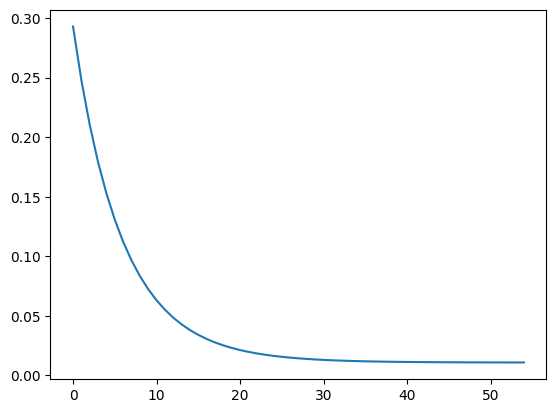

In [545]:
plt.plot(cost_func)
plt.show()



In [546]:
X_cond_sc

tensor([[-0.6011, -0.2945, -0.0200]], dtype=torch.float64)

In [547]:
mean_gk_org_dim=sc_y.inverse_transform([mean_pred])
lower_gk_org_dim=sc_y.inverse_transform([lower_pred])
upper_gk_org_dim=sc_y.inverse_transform([upper_pred])
optim_cond_gk=sc_X.inverse_transform(X_cond_sc)

In [548]:
print("Required Parameters:")
print(y_req)
print("Optimum Conditions for synthesis:")
print(optim_cond_gk)
print("Parameters Obtained:")
print(mean_gk_org_dim)

Required Parameters:
[[ 0.4   3.2  -0.02]]
Optimum Conditions for synthesis:
[[ 2.13638733  2.56996923 29.90653763]]
Parameters Obtained:
[[4.09257726e-01 3.20085731e+00 7.51428717e-05]]


## MOGP Joint Inference using RBF

In [549]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=3
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=3, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood_mogp = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)

In [550]:
X_32_sc=X_sc.to(torch.float32)
y_32_sc=y_sc.to(torch.float32)

In [551]:
model_mogp = MultitaskGPModel(X_32_sc,y_32_sc,likelihood_mogp)

In [552]:
training_iterations =50


# Find optimal model hyperparameters
model_mogp.train()
likelihood_mogp.train()

# Use the adam optimizer
optimizer_mogp = torch.optim.Adam(model_mogp.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll_mogp = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_mogp, model_mogp)

for i in range(training_iterations):
    optimizer_mogp.zero_grad()
    output_mogp = model_mogp(X_32_sc)
    loss_mogp = -mll_mogp(output_mogp,y_32_sc)
    loss_mogp.backward()
    optimizer_mogp.step()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [553]:
mean_params = model_mogp.mean_module.state_dict()
covar_params = model_mogp.covar_module.task_covar_module.covar_matrix.numpy()

In [554]:
mean_params

OrderedDict([('base_means.0.raw_constant', tensor(0.4283)),
             ('base_means.1.raw_constant', tensor(-0.3611)),
             ('base_means.2.raw_constant', tensor(-0.3279))])

In [555]:
covar_params

array([[ 2.9513407 ,  0.99652964, -2.7343302 ],
       [ 0.99652964,  3.549596  , -0.9302947 ],
       [-2.7343302 , -0.9302947 ,  2.5694666 ]], dtype=float32)

In [556]:
wt_guess=2.6
salt_guess=3
temp_guess=30
X_cond=np.reshape(np.array([wt_guess,salt_guess,temp_guess]),(1,-1))
X_cond_sc_mogp=sc_X.transform(X_cond)
X_cond_sc_mogp=torch.tensor(X_cond_sc_mogp)
X_cond_sc_mogp=X_cond_sc_mogp.to(torch.float32)

In [557]:
X_cond_sc_mogp

tensor([[ 0.0234, -0.1065,  0.0000]])

In [558]:
# Set into eval mode
model_mogp.eval()
likelihood_mogp.eval()
grad_step_sz=1e-2
lr_rate=[1e-2,1e-2,1e-2]
J_prev=100
J=0
cost_func=[]
while(abs(J_prev-J)>1e-3):
    print("Begin X")
    print(X_cond_sc_mogp)
    J_prev=J
    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions_mogp = likelihood_mogp(model_mogp(X_cond_sc_mogp))
        mean_mogp = predictions_mogp.mean
        lower_mogp, upper_mogp = predictions_mogp.confidence_region()
    J=error_est(y_req_sc[0],np.array(mean_mogp)[0],np.array(lower_mogp)[0],np.array(upper_mogp)[0],X_cond_sc_mogp[0])
    print("Cost Function")
    print(J)
    print("Parameters Obtained:")
    print(mean_mogp)
    grad=[1,1,1]
    for j in range(3):
        X1=X_cond_sc_mogp.clone().detach()
        X1[0][j]+=grad_step_sz
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions_mogp = likelihood_mogp(model_mogp(X1))
            mean_mogp = predictions_mogp.mean
            lower_mogp, upper_mogp = predictions_mogp.confidence_region()
        J1=error_est(y_req_sc[0],np.array(mean_mogp)[0],np.array(lower_mogp)[0],np.array(upper_mogp)[0],X_cond_sc_mogp[0])
        print("Cost Function for grad ", j)
        print(J1)
        grad[j]=(J1-J)/(grad_step_sz)
    print("Gradients")
    print(grad)
    X_cond_sc_mogp=X_cond_sc_mogp-np.multiply(lr_rate,grad)
    X_cond_sc_mogp=torch.tensor(X_cond_sc_mogp)
    X_cond_sc_mogp=X_cond_sc_mogp.to(torch.float32)
    cost_func.append(J)
   

Begin X
tensor([[ 0.0234, -0.1065,  0.0000]])
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced V

/var/folders/r7/2_r0cpxd4vz87rt3d7z1b4fc0000gn/T/ipykernel_22415/555838512.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_cond_sc_mogp=torch.tensor(X_cond_sc_mogp)


 2
0.11027749528439312
Gradients
[1.6272593995074858, 0.3576398383269272, 0.10585209624901504]
Begin X
tensor([[-0.4837, -0.3382, -0.0393]])
Cost Function
0.08494119471021555
Parameters Obtained:
tensor([[ 0.2618,  1.0393, -0.2422]])


Cost Function for grad  0
0.09871063832881043
Cost Function for grad  1
0.08734694059141038
Cost Function for grad  2
0.0857543122298782
Gradients
[1.3769443618594877, 0.24057458811948262, 0.08131175196626483]
Begin X
tensor([[-0.4975, -0.3406, -0.0401]])
Cost Function
0.06795656130490613
Parameters Obtained:
tensor([[ 0.2745,  1.0567, -0.2540]])
Cost Function for grad  0
0.07963542900582014
Cost Function for grad  1
0.06947535705776706
Cost Function for grad  2
0.06858935838685123
Gradients
[1.1678867700914017, 0.15187957528609297, 0.06327970819451079]
Begin X
tensor([[-0.5091, -0.3422, -0.0408]])
Cost Function
0.056017183029930424
Parameters Obtained:
tensor([[ 0.2854,  1.0708, -0.2642]])
Cost Function for grad  0
0.06596014636454721
Cost Function for grad  1
0.056800522435556215
Cost Function for grad  2
0.056524692066257015
Gradients
[0.9942963334616784, 0.07833394056257909, 0.05075090363265908]
Begin X
tensor([[-0.5191, -0.3429, -0.0413]])
Cost Function
0.04749441735005235
Paramet

In [559]:
np.array(mean_mogp)[0]

array([ 0.33573002,  1.1177067 , -0.3122634 ], dtype=float32)

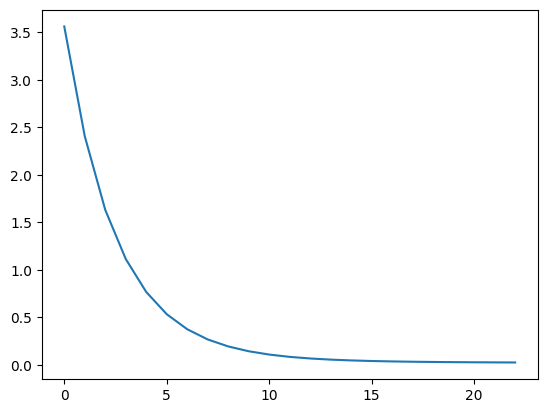

In [560]:
plt.plot(cost_func)
plt.show()

In [561]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    mean_mogp = predictions_mogp.mean
    predictions_mogp = likelihood_mogp(model_mogp(X_cond_sc_mogp))
    lower_mogp, upper_mogp = predictions_mogp.confidence_region()

In [562]:
mean_mogp_org_dim=sc_y.inverse_transform(mean_mogp)
lower_mogp_org_dim=sc_y.inverse_transform(lower_mogp)
upper_mogp_org_dim=sc_y.inverse_transform(upper_mogp)
optim_cond_mogp=sc_X.inverse_transform(X_cond_sc_mogp)

In [563]:
print("Required Parameters:")
print(y_req)
print("Optimum Conditions for synthesis:")
print(optim_cond_mogp)
print("Parameters Obtained:")
print(mean_mogp_org_dim)

Required Parameters:
[[ 0.4   3.2  -0.02]]
Optimum Conditions for synthesis:
[[ 2.16349075  2.47568979 29.8005421 ]]
Parameters Obtained:
[[0.40553927 3.20857302 0.05346222]]


In [564]:
y_req_sc

array([[ 0.29448277,  1.10374981, -0.3971704 ]])

In [565]:
lower_mogp

tensor([[ 0.0061,  0.8003, -0.6044]])

In [566]:
upper_mogp

tensor([[ 0.6720,  1.4396, -0.0264]])

In [567]:
mean_mogp

tensor([[ 0.3357,  1.1177, -0.3123]])